In [27]:
import warnings
warnings.filterwarnings("ignore")

In [28]:
# dl kaggle data - https://www.kaggle.com/datasets/dhruvildave/en-fr-translation-dataset?select=en-fr.csv

import os
import kagglehub

dir = kagglehub.dataset_download("dhruvildave/en-fr-translation-dataset")
filename = 'en-fr.csv'
filepath = os.path.join(dir, filename)

In [ ]:
import torch

# set the seed for reproducibility
torch.manual_seed(12)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(12)

In [29]:
# extract data and construct Q, K, V vectors

import pandas as pd
import torch
from typing import Tuple, List
from transformers import AutoTokenizer


CSV_PATH = filepath
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pre-trained tokenizer
TOKENIZER = AutoTokenizer.from_pretrained("t5-small", model_max_length=N)


# extract the raw data and structure Q, K, V, Y_true tensors
def extract_data(
        batch_size: int,
        seq_len: int,
        d_model: int,
        device: torch.device = DEVICE,
        csv_path: str = CSV_PATH
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]: # q, k, v, y_true

    chunk_iterator = pd.read_csv(
        csv_path, 
        chunksize=batch_size * 2,
        header=None, # ignore file header
        names=['en', 'fr'],
        usecols=['en', 'fr'], 
        on_bad_lines='skip'
    )
    first_chunk = next(chunk_iterator)

    # tokenization and padding for input data (en)
    raw_english_sentences: List[str] = first_chunk['en'].astype(str).tolist()[:batch_size]
    tokenized_inputs = TOKENIZER(raw_english_sentences, padding='max_length', truncation=True, max_length=seq_len, return_tensors='pt')
    
    # tokenization and padding for the target data (fr)
    raw_french_sentences: List[str] = first_chunk['fr'].astype(str).tolist()[:batch_size]
    tokenized_targets = TOKENIZER(raw_french_sentences, padding='max_length', truncation=True, max_length=seq_len, return_tensors='pt')
    
    # total tokens 
    N_tokens = tokenized_inputs['input_ids'].shape[1]
    
    # simulate Q, K, V vectors (used by the encoder)
    Q = torch.randn(batch_size, N_tokens, d_model, device=device)
    K = torch.randn(batch_size, N_tokens, d_model, device=device)
    V = torch.randn(batch_size, N_tokens, d_model, device=device)
    
    # true fr target token ids to compute loss
    Y_true = tokenized_targets['input_ids'].to(device)
    
    return Q, K, V, Y_true


# extract train and test data with different sequence length
N = 2048
N_TEST = 4096
D_MODEL = 512
BATCH_SIZE = 4
CSV_PATH = filepath

Q_base, K_base, V_base, Y_true_base = extract_data(BATCH_SIZE, N, D_MODEL, DEVICE)
Q_test, K_test, V_test, Y_true_test = extract_data(BATCH_SIZE, N_TEST, D_MODEL, DEVICE)


In [30]:
# define the attention layers 

import torch
import torch.nn as nn
import torch.nn.functional as f

# standard mha self-attention (o(n^2))
class StandardMHA(nn.Module):
    def __init__(self, d_k: int):
        super().__init__()
        self.scaling_factor = 1 / (d_k ** 0.5)

    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor) -> torch.Tensor:
        S = torch.matmul(Q, K.transpose(-2, -1)) * self.scaling_factor # scaled score s
        A = torch.softmax(S, dim=-1) # attention vector a
        Z = torch.matmul(A, V) # context vector z - [b, n, d]
        return Z
    

# linformer attention (o(nl))
class Linformer(nn.Module):
    def __init__(self, N_max: int, L: int, d_k: int):
        super().__init__()
        # use n_max (which is n from global) to size the projection matrix
        self.E = nn.Parameter(torch.randn(N_max, L, device=DEVICE), requires_grad=True) # projection vector (learned parameter unique to linformer)
        self.scaling_factor = 1 / (d_k ** 0.5)

    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor) -> torch.Tensor:
        N_curr = K.shape[1]
        
        # fix: allow the projection matrix to handle sequences up to its max size (n)
        if N_curr > self.E.shape[0]:
             raise RuntimeError(f"... linformer: sequence length {N_curr} exceeds fixed projection size {self.E.shape[0]}. failed to generalize ...")
        
        # limited elements l (use the necessary part of the learned projection)
        L_proj = self.E[:N_curr, :] # use l_proj to avoid name conflict with l in self.e

        # compress key and value vectors using l
        K_compressed = torch.matmul(K.transpose(-2, -1), L_proj).transpose(-2, -1)
        V_compressed = torch.matmul(V.transpose(-2, -1), L_proj).transpose(-2, -1)
        
        # compute context vector z
        S = torch.matmul(Q, K_compressed.transpose(-2, -1)) * self.scaling_factor
        A = torch.softmax(S, dim=-1) 
        Z = torch.matmul(A, V_compressed)
        return Z


# performer attention (o(n))
class Performer(nn.Module):
    def __init__(self, d_model: int, m_features: int):
        super().__init__()
        self.m = m_features
        self.d_model = d_model
        # random features normalized by 1/sqrt(m)
        self.random_features = nn.Parameter(torch.randn(d_model, m_features, device=DEVICE) / (m_features ** 0.5), requires_grad=False) # fixed random features
        
    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor) -> torch.Tensor:
        # simplified rfa approximation: exp(q' * k') * v / exp(q' * sum(k'))
        
        # apply elu + 1 to the feature map for positive approximation of exp(x)
        Q_prime = f.elu(torch.matmul(Q, self.random_features)) + 1
        K_prime = f.elu(torch.matmul(K, self.random_features)) + 1
        
        # term 1: k_prime.t @ v -> [b, m, d_model]  - numerator: q_prime @ term 1 -> [b, n, d_model]
        numerator_term_1 = torch.matmul(K_prime.transpose(-2, -1), V)
        numerator = torch.matmul(Q_prime, numerator_term_1)
        
        # denominator term 1: sum(k_prime) -> [b, 1, m]
        denominator_term_1 = torch.sum(K_prime, dim=1).unsqueeze(1)
        denominator = torch.matmul(Q_prime, denominator_term_1.transpose(-2, -1)) 
        
        epsilon = 1e-6 # increased epsilon slightly for stability
        Z = numerator / (denominator + epsilon)
        return Z
    

# longformer (o(nw))
class Longformer(nn.Module):
    def __init__(self, window_size: int, d_k: int):
        super().__init__()
        self.w = window_size
        self.scaling_factor = 1 / (d_k ** 0.5)
        self.neg_inf = -1e9

    def _create_local_mask(self, N_curr: int, device: torch.device) -> torch.Tensor:
        indices = torch.arange(N_curr, device=device).unsqueeze(-1)
        diff_matrix = torch.abs(indices - indices.transpose(0, 1))
        mask = (diff_matrix <= self.w)
        return mask.bool()

    def forward(self, Q: torch.Tensor, K: torch.Tensor, V: torch.Tensor) -> torch.Tensor:
        B, N_curr, _ = Q.shape

        S = torch.matmul(Q, K.transpose(-2, -1)) * self.scaling_factor # attention scores 

        # create and apply a mask m
        local_mask = self._create_local_mask(N_curr, Q.device)
        M = local_mask.unsqueeze(0).expand(B, -1, -1)
        masked_scores = S.masked_fill(~M, self.neg_inf)

        # compute z
        A = torch.softmax(masked_scores, dim=-1)
        Z = torch.matmul(A, V)
        return Z

In [31]:
# standard encoder layer w/ attention module
class EncoderLayer(nn.Module):
    def __init__(self, attention_module: nn.Module, d_model: int):
        super().__init__()
        self.attn = attention_module # takes one of the four attention classes
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # attention block
        norm_x = self.norm1(x)

        # encoder has the same q, k, v (norm_x, norm_x, norm_x)
        attn_out = self.attn(norm_x, norm_x, norm_x)
        x = x + self.dropout1(attn_out) # residual connection

        # feed-forward block
        norm_x = self.norm2(x)
        ffn_out = self.ffn(norm_x)
        output = x + self.dropout2(ffn_out) # residual connection
        return output


# standard decoder layer
class DecoderLayer(nn.Module):
    def __init__(self, attention_module: nn.Module, d_model: int):
        super().__init__()
        # decoder self-attention (same type as encoder for this simulation)
        self.self_attn = attention_module 
        # encoder-decoder attention
        self.cross_attn = StandardMHA(d_model) # apply standardmha
        
        self.ffn = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Linear(d_model * 4, d_model)
        )
        
        self.norm1 = nn.LayerNorm(d_model) # self-attn norm
        self.norm2 = nn.LayerNorm(d_model) # cross-attn norm
        self.norm3 = nn.LayerNorm(d_model) # ffn norm
        self.dropout1 = nn.Dropout(0.1)
        self.dropout2 = nn.Dropout(0.1)
        self.dropout3 = nn.Dropout(0.1)

    # takes the decoder input (tgt) and the encoder output (mem)
    def forward(self, tgt: torch.Tensor, mem: torch.Tensor) -> torch.Tensor:     
        # masked decoder self-attention (q = k = v = tgt)
        norm_tgt = self.norm1(tgt)
        self_attn_out = self.self_attn(norm_tgt, norm_tgt, norm_tgt) 
        tgt = tgt + self.dropout1(self_attn_out) # residual connection

        # encoder-decoder cross-attention (q = tgt, k = v = mem)
        norm_tgt = self.norm2(tgt)
        cross_attn_out = self.cross_attn(norm_tgt, mem, mem) 
        tgt = tgt + self.dropout2(cross_attn_out) # residual connection

        # feed-forward block
        norm_tgt = self.norm3(tgt)
        ffn_out = self.ffn(norm_tgt)
        output = tgt + self.dropout3(ffn_out) # residual connection
        return output


# full model
class TransformerSeq2Seq(nn.Module):
    def __init__(self, attention_module: nn.Module, d_model: int, vocab_size: int, pad_token_id: int):
        super().__init__()
        # encoder layer
        self.encoder = EncoderLayer(attention_module, d_model)

        # decoder layer
        self.decoder = DecoderLayer(attention_module, d_model)
        
        # target token embedding
        self.target_embedding = nn.Embedding(vocab_size, d_model)
        
        # final linear/softmax head for logits
        self.linear_head = nn.Linear(d_model, vocab_size)

        # store pad id for mask generation
        self.pad_token_id = pad_token_id


    def forward(self, Q, K, V, Y_true):
        # encoder (q, k, v are used in the encoder layer to create encoded memory)
        mem = self.encoder(Q)
        # the decoder input is the true target tokens shifted right
        tgt_input_tokens = Y_true[:, :-1]
        tgt = self.target_embedding(tgt_input_tokens)
        decoder_output = self.decoder(tgt, mem)
        logits = self.linear_head(decoder_output)
        return logits



In [32]:
from transformers import AutoTokenizer


# pre-trained tokenizer
TOKENIZER = AutoTokenizer.from_pretrained("t5-small", model_max_length=N)
VOCAB_SIZE = TOKENIZER.vocab_size


# full seq2seq transformers using diff attention mechanisms
class TransformerStandard(Seq2SeqTransformer):
    def __init__(self, d_model: int, vocab_size: int):
        attn = StandardMHA(d_model)
        pad_id = TOKENIZER.pad_token_id
        super().__init__(attn, d_model, vocab_size, pad_token_id=pad_id)


class TransformerLinformer(Seq2SeqTransformer):
    def __init__(self, N_max: int, L: int, D_MODEL: int, vocab_size: int):
        attn = Linformer(N_max, L, D_MODEL)
        pad_id = TOKENIZER.pad_token_id
        super().__init__(attn, D_MODEL, vocab_size, pad_token_id=pad_id)


class TransformerPerformer(Seq2SeqTransformer):
    def __init__(self, D_MODEL: int, m_PERFORMER: int, vocab_size: int):
        attn = Performer(D_MODEL, m_PERFORMER)
        pad_id = TOKENIZER.pad_token_id
        super().__init__(attn, D_MODEL, vocab_size, pad_token_id=pad_id)

class TransformerLongformer(Seq2SeqTransformer):
    def __init__(self, w_LONGFORMER: int, D_MODEL: int, vocab_size: int):
        attn = Longformer(w_LONGFORMER, D_MODEL)
        pad_id = TOKENIZER.pad_token_id
        super().__init__(attn, D_MODEL, vocab_size, pad_token_id=pad_id)



# instantiate full seq2seq transformer models

D_MODEL = 512
L_LINFORMER = 128   # linformer compressed sequence length L << N
m_PERFORMER = 256   # performer number of random features m < D
w_LONGFORMER = 128  # longformer local window size w << N

models = {
    '1. Standard MHA': TransformerStandard(D_MODEL, VOCAB_SIZE).to(DEVICE),
    '2. Linformer': TransformerLinformer(Q_base.shape[1], L_LINFORMER, D_MODEL, VOCAB_SIZE).to(DEVICE), 
    '3. Performer': TransformerPerformer(D_MODEL, m_PERFORMER, VOCAB_SIZE).to(DEVICE),
    '4. LongFormer': TransformerLongformer(w_LONGFORMER, D_MODEL, VOCAB_SIZE).to(DEVICE),
}

In [33]:
# training

EPOCHS = 3000
LEARNING_RATE = 1e-5


# early stopping 
class EarlyStopper:
    # increased patience for distillation
    def __init__(self, patience: int = 20, min_delta: float = 1e-10, is_distillation: bool = False):
        self.patience = patience * 5 if is_distillation else patience # increased patience for kd
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss: float) -> bool:
        if validation_loss < self.min_validation_loss - self.min_delta:
            self.min_validation_loss = validation_loss
            self.counter = 0
        
        elif validation_loss > self.min_validation_loss + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience: return True

        return False


# training standard mha
def train(
        model: nn.Module,
        Q: torch.Tensor,
        K: torch.Tensor,
        V: torch.Tensor,
        Y_true: torch.Tensor,
        num_steps: int = EPOCHS,
        lr: float = LEARNING_RATE
        ) -> torch.Tensor:
    
    print(f"... training standard mha for stabilization ...")
    
    # target - the model's own random initial output logits
    model.eval()
    with torch.no_grad():
        init_output = model(Q, K, V, Y_true).detach()

    # optimize params
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    
    # loss & early stop
    criterion = nn.CrossEntropyLoss(ignore_index=TOKENIZER.pad_token_id)

    # training mode
    model.train()
    Y_target = Y_true[:, 1:].flatten()
    # teacher target labels for mse/ce-proxy stabilization
    target = init_output.view(-1, init_output.shape[-1]).detach()
    
    # use default patience for stabilization
    early_stopper = EarlyStopper(patience=20)
    
    # training epochs
    for step in range(num_steps):
        optimizer.zero_grad()
        output_logits = model(Q, K, V, Y_true)
        output_for_loss = output_logits.view(-1, output_logits.shape[-1]) # teshape output_logits to [b*n_tokens, vocab_size]
        
        # stabilization loss (mse proxy used originally, kept here for consistency with original logic)
        loss = f.mse_loss(output_for_loss, target) # changed to f.mse_loss for clarity
        loss.backward() 
        optimizer.step()
        
        # calculate the true language loss for reporting and early stopping
        with torch.no_grad():
            true_loss = criterion(output_for_loss, Y_target) 
            
        if (step + 1) % 10 == 0:
            print(f"... step {step + 1}/{num_steps}, stabilization loss (mse-proxy): {loss.item():.6f}, true ce loss: {true_loss.item():.6f}")

        # early stop
        if early_stopper.early_stop(true_loss.item()):
            print(f"... early stopping triggered at step {step + 1}. no improvement in true ce loss for {early_stopper.patience} steps.")
            break
    
    model.eval()
    print("  stabilization finished")
    # return the trained output logits (used as the stable distillation target)
    with torch.no_grad():
        return model(Q, K, V, Y_true)
    


# train the standard mha to get stable targets
standard_output_target_logits = train(
    models['1. Standard MHA'], Q_base, K_base, V_base, Y_true_base
)


# get the test target logits from the trained mha
with torch.no_grad():
    standard_output_test_target_logits = models['1. Standard MHA'](Q_test, K_test, V_test, Y_true_test)


... training standard mha for stabilization ...
... step 10/3000, stabilization loss (mse-proxy): 0.056099, true ce loss: 11.121469
... step 20/3000, stabilization loss (mse-proxy): 0.054745, true ce loss: 11.174870
... step 30/3000, stabilization loss (mse-proxy): 0.053823, true ce loss: 11.151731
... step 40/3000, stabilization loss (mse-proxy): 0.053645, true ce loss: 11.196956
... step 50/3000, stabilization loss (mse-proxy): 0.052099, true ce loss: 11.181365
... early stopping triggered at step 59. no improvement in true ce loss for 20 steps.
  stabilization finished


In [34]:
import torch

# kd for the attention approx models
EPOCHS = 3000
LEARNING_RATE = 1e-5
DISTILLATION_TEMP = 3.0 # temperature for distillation
ALPHA = 0.5

def run_distillation_simulation(
        model: nn.Module,
        Q: torch.Tensor,
        K: torch.Tensor,
        V: torch.Tensor,
        Y_true: torch.Tensor,
        target_model_name: str,
        stable_target_logits: torch.Tensor,
        num_steps: int = EPOCHS,
        lr: float = LEARNING_RATE):
 
    print(f"\n... training {target_model_name} (runs distillation) ...")
    
    # define optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # loss functions
    ce_loss = nn.CrossEntropyLoss(ignore_index=TOKENIZER.pad_token_id)
    
    # set training mode
    model.train()

    # reshape target for cross-entropy loss (hard labels)
    Y_target = Y_true[:, 1:].flatten()
    
    # reshape stable_target_logits (teacher's output)
    stable_target_for_loss = stable_target_logits.view(-1, stable_target_logits.shape[-1]).detach()

    # early stopper (uses increased patience)
    early_stopper = EarlyStopper(is_distillation=True)
    
    # a utility function for kl-divergence on soft targets (kd loss)
    def distillation_loss(student_logits, teacher_logits, temperature, alpha, true_labels):
        # soft targets
        student_log_softmax = f.log_softmax(student_logits / temperature, dim=-1)
        teacher_softmax = f.softmax(teacher_logits / temperature, dim=-1)
        
        # kl divergence loss
        kd_loss = f.kl_div(student_log_softmax, teacher_softmax, reduction='batchmean') * (temperature ** 2)
        
        # hard targets - standard cross entropy loss on true labels
        hard_loss = ce_loss(student_logits, true_labels)
        
        # combined loss
        return alpha * hard_loss + (1.0 - alpha) * kd_loss

    for step in range(num_steps):
        optimizer.zero_grad()
        output_logits = model(Q, K, V, Y_true)
        output_for_loss = output_logits.view(-1, output_logits.shape[-1])   
        
        # combined distillation loss (kl + ce)
        loss = distillation_loss(
            student_logits=output_for_loss, 
            teacher_logits=stable_target_for_loss, 
            temperature=DISTILLATION_TEMP, 
            alpha=ALPHA, 
            true_labels=Y_target
        )
        
        loss.backward()
        optimizer.step()
        
        # calculate the true language loss for reporting and early stopping
        with torch.no_grad():
            # use the standard ce loss for the true performance metric
            true_loss = ce_loss(output_for_loss, Y_target)
            
        if (step + 1) % 10 == 0:
            # print the actual distillation loss and the true ce loss
            print(f"... step {step + 1}/{num_steps}, distillation loss (kl+ce): {loss.item():.6f}, true ce loss: {true_loss.item():.6f}")

        if early_stopper.early_stop(true_loss.item()):
            print(f"... early stopping triggered at step {step + 1}. no improvement in true ce loss for {early_stopper.patience} steps.")
            break
    model.eval()
    print("  distillation simulation finished.")


# loop the rest of the models
for name, model in models.items():
    if name != '1. Standard MHA':
        run_distillation_simulation(
            model=model,
            Q=Q_base,
            K=K_base,
            V=V_base,
            Y_true=Y_true_base,
            target_model_name=name, 
            stable_target_logits=standard_output_target_logits,
            num_steps=EPOCHS,
        )
    
    # ensure inputs are detached for timing and evaluation
    Q_base.requires_grad_(False); K_base.requires_grad_(False); V_base.requires_grad_(False)
    Q_test.requires_grad_(False); K_test.requires_grad_(False); V_test.requires_grad_(False)
    Y_true_base.requires_grad_(False); Y_true_test.requires_grad_(False)
    



... training 2. Linformer (runs distillation) ...
... step 10/3000, distillation loss (kl+ce): 537.723511, true ce loss: 220.702454
... step 20/3000, distillation loss (kl+ce): 511.943176, true ce loss: 212.297791
... step 30/3000, distillation loss (kl+ce): 499.441406, true ce loss: 205.379791
... step 40/3000, distillation loss (kl+ce): 477.980011, true ce loss: 195.795212
... step 50/3000, distillation loss (kl+ce): 458.094971, true ce loss: 192.494278
... step 60/3000, distillation loss (kl+ce): 448.312256, true ce loss: 193.697418
... step 70/3000, distillation loss (kl+ce): 426.097473, true ce loss: 185.250244
... step 80/3000, distillation loss (kl+ce): 410.909637, true ce loss: 178.366074
... step 90/3000, distillation loss (kl+ce): 396.223907, true ce loss: 179.335022
... step 100/3000, distillation loss (kl+ce): 379.740814, true ce loss: 167.173355
... step 110/3000, distillation loss (kl+ce): 367.865540, true ce loss: 170.198151
... step 120/3000, distillation loss (kl+ce):

In [38]:
import time
from typing import Dict

def perform_inference() -> Dict[str, Dict[str, float]]: 

    results: Dict[str, Dict[str, float]] = dict()
    
    # define loss
    final_criterion = nn.CrossEntropyLoss(ignore_index=TOKENIZER.pad_token_id, reduction='mean') 
    
    # reshape true token targets for loss calc
    Y_target_base_flat = Y_true_base[:, 1:].flatten()
    Y_target_test_flat = Y_true_test[:, 1:].flatten()

    # perform inference
    for name, model in models.items():
        # warm up runs
        for _ in range(5):
            _ = model(Q_base, K_base, V_base, Y_true_base)
        
        NUM_RUNS = 10
        
        # timing setup
        if DEVICE.type == 'cuda':
            torch.cuda.synchronize()

            start_event = torch.cuda.Event(enable_timing=True)
            end_event = torch.cuda.Event(enable_timing=True)

            start_event.record() # type: ignore
            with torch.no_grad():
                for _ in range(NUM_RUNS):
                    output_logits_base = model(Q_base, K_base, V_base, Y_true_base)
            end_event.record() # type: ignore
        
            torch.cuda.synchronize()

            avg_time = start_event.elapsed_time(end_event) / 1000 / NUM_RUNS # compute avg. time
        else:
            # fallback to cpu
            start_time = time.time()
            with torch.no_grad():
                for _ in range(NUM_RUNS):
                     output_logits_base = model(Q_base, K_base, V_base, Y_true_base)
            avg_time = (time.time() - start_time) / NUM_RUNS
        
        
        # analysis 1 - accuracy vs. sparsity / rank (approximation quality)
        output_logits_base_flat = output_logits_base.view(-1, output_logits_base.shape[-1])
        standard_output_target_logits_flat = standard_output_target_logits.view(-1, standard_output_target_logits.shape[-1])
        
        if name == '1. Standard MHA':
            # standard model's loss against true labels (ce loss)
            mse_accuracy = final_criterion(output_logits_base_flat, Y_target_base_flat).item() 
        else:
            # approximation model's loss (mse between logits of student and teacher)
            mse_accuracy = f.mse_loss(output_logits_base_flat, standard_output_target_logits_flat).item() 
            
        
        # analysis 2 - generalization (approximation on n_test)
        try:
            with torch.no_grad():
                output_logits_test = model(Q_test, K_test, V_test, Y_true_test)
            
            output_logits_test_flat = output_logits_test.view(-1, output_logits_test.shape[-1])
            standard_output_test_target_logits_flat = standard_output_test_target_logits.view(-1, standard_output_test_target_logits.shape[-1])
            
            if name == '1. Standard MHA':
                 mse_test = final_criterion(output_logits_test_flat, Y_target_test_flat).item()
                 generalization_ratio = 1.0  # as target model 
            else:
                mse_test = f.mse_loss(output_logits_test_flat, standard_output_test_target_logits_flat).item()
                if mse_accuracy > 1e-9: generalization_ratio = mse_test / mse_accuracy
                else: generalization_ratio = 1.0
            
        except RuntimeError as e:
            # generalization is allowed to fail only if seq len exceeds n_max
            if 'exceeds fixed projection size' in str(e) and name == '2. Linformer':
                print(f"  [{name}]: generalization test failed (sequence length error: {e})")
            else:
                # for performer or longformer, a runtime error is a major failure
                print(f"  [{name}]: generalization test failed (unexpected error: {e})")

            mse_test = 1000.0 
            generalization_ratio = 1000.0 
            
        print(f"[{name}]: Avg Time: {avg_time:.4f}s | Metric (Accuracy Proxy): {mse_accuracy:.6f} | Gen. Ratio: {generalization_ratio:.2f}")

        # store results
        results[name] = {
            "Practical Speed (s)": avg_time,
            "Approximation Quality (Metric)": mse_accuracy, 
            "Generalization Factor (Test Metric / Base Metric)": generalization_ratio
        }

    return results


# inference
results = perform_inference()

[1. Standard MHA]: Avg Time: 0.3066s | Metric (Accuracy Proxy): 11.122578 | Gen. Ratio: 1.00
  [2. Linformer]: generalization test failed (sequence length error: ... linformer: sequence length 4096 exceeds fixed projection size 2048. failed to generalize ...)
[2. Linformer]: Avg Time: 0.2425s | Metric (Accuracy Proxy): 11611.545898 | Gen. Ratio: 1000.00
[3. Performer]: Avg Time: 0.2377s | Metric (Accuracy Proxy): 0.606014 | Gen. Ratio: 1.04
[4. LongFormer]: Avg Time: 0.3163s | Metric (Accuracy Proxy): 0.414362 | Gen. Ratio: 0.94


In [39]:
print("\n--- summary of the analysis ---")
for name, metrics in results.items():
    print(f"**{name.split('. ')[1]}**:")
    print(f"  * Speed: {metrics['Practical Speed (s)']:.4f}s")
    print(f"  * Metric: {metrics['Approximation Quality (Metric)']:.6f}")
    print(f"  * Generalization Factor: {metrics['Generalization Factor (Test Metric / Base Metric)']:.2f}")


--- summary of the analysis ---
**Standard MHA**:
  * Speed: 0.3066s
  * Metric: 11.122578
  * Generalization Factor: 1.00
**Linformer**:
  * Speed: 0.2425s
  * Metric: 11611.545898
  * Generalization Factor: 1000.00
**Performer**:
  * Speed: 0.2377s
  * Metric: 0.606014
  * Generalization Factor: 1.04
**LongFormer**:
  * Speed: 0.3163s
  * Metric: 0.414362
  * Generalization Factor: 0.94


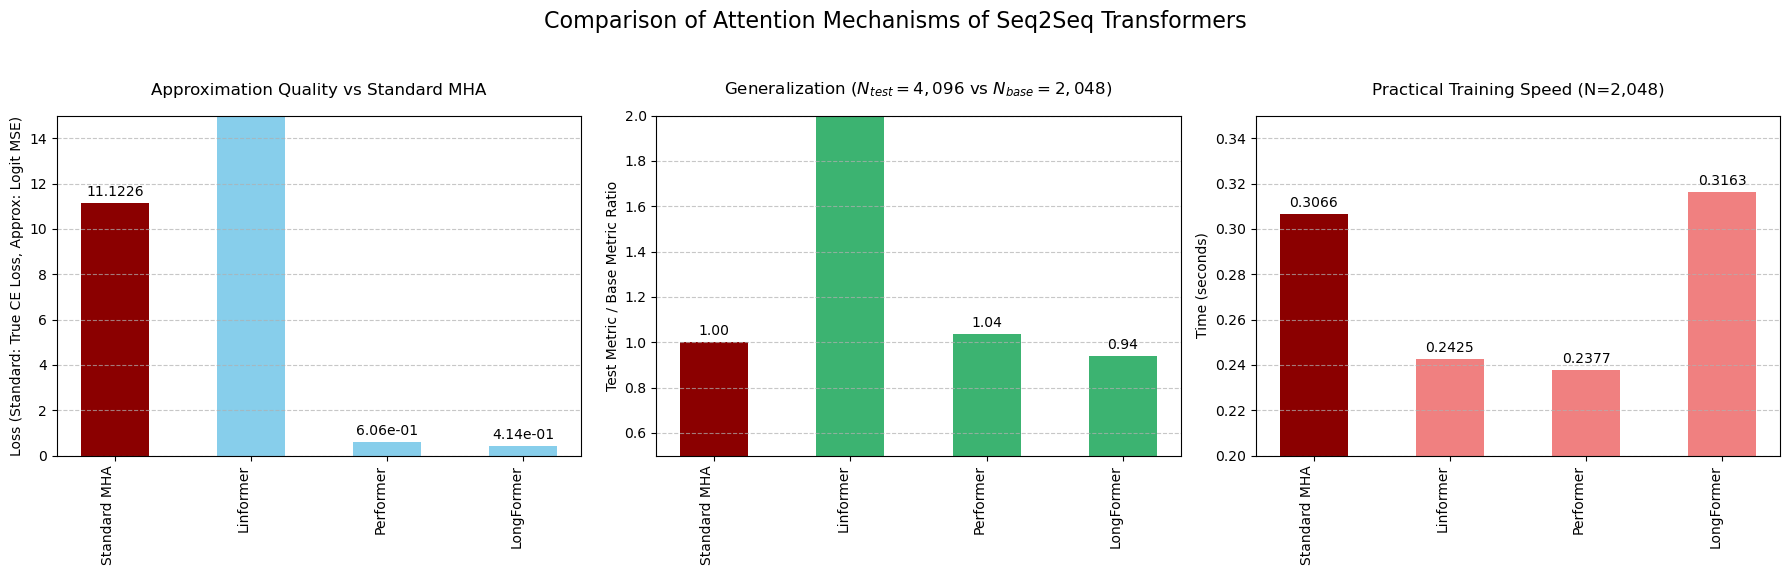

In [40]:
# plot the results

import numpy as np
import matplotlib.pyplot as plt


def plot_comparison(results: Dict[str, Dict[str, float]]) -> None:
    names_full = list(results.keys())
    accuracy = [results[name]["Approximation Quality (Metric)"] for name in names_full]
    generalization = [results[name]["Generalization Factor (Test Metric / Base Metric)"] for name in names_full]
    speed = [results[name]["Practical Speed (s)"] for name in names_full]

    x = np.arange(len(names_full)) 
    std_speed_ref = results["1. Standard MHA"]["Practical Speed (s)"]
    std_ce_loss = results["1. Standard MHA"]["Approximation Quality (Metric)"]
    clean_names = [n.split('. ')[1] for n in names_full]
        
    _, axes = plt.subplots(1, 3, figsize=(18, 6))
    plt.suptitle('Comparison of Attention Mechanisms of Seq2Seq Transformers', fontsize=16)

    ax1 = axes[0]
    colors1 = ['darkred'] + ['skyblue'] * (len(x) - 1)
    ax1.set_ylim(bottom=0.0, top=15)
    ax1.set_ylabel('Loss (Standard: True CE Loss, Approx: Logit MSE)', color='black')
    ax1.set_title('Approximation Quality vs Standard MHA', pad=15)
    ax1.set_xticks(x)
    ax1.set_xticklabels(clean_names, rotation=90, ha="right")
    ax1.grid(axis='y', linestyle='--', alpha=0.7)
    bars1 = ax1.bar(x, accuracy, width=0.5, color=colors1)
    for i, bar in enumerate(bars1):
        height = bar.get_height()
        ax1.annotate(f'{height:.2e}' if i > 0 else f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3),    textcoords="offset points",  ha='center', va='bottom')

    ax2 = axes[1]
    colors2 = ['darkred'] + ['mediumseagreen'] * (len(x) - 1)
    ax2.set_ylim(bottom=0.5, top=2.0)
    ax2.set_ylabel('Test Metric / Base Metric Ratio', color='black')
    ax2.set_title(f'Generalization ($N_{{test}}={N_TEST:,}$ vs $N_{{base}}={N:,}$)', pad=15)
    ax2.set_xticks(x)
    ax2.set_xticklabels(clean_names, rotation=90, ha="right")
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    bars2 = ax2.bar(x, generalization, width=0.5, color=colors2)
    for bar in bars2:
        height = bar.get_height()
        ax2.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')


    ax3 = axes[2]
    colors3 = ['darkred'] + ['lightcoral'] * (len(x) - 1)
    ax3.set_ylim(bottom=0.2, top=0.35)
    ax3.set_ylabel('Time (seconds)', color='black')
    ax3.set_title(f'Practical Training Speed (N={N:,})', pad=15)
    ax3.set_xticks(x)
    ax3.set_xticklabels(clean_names, rotation=90, ha="right")
    ax3.grid(axis='y', linestyle='--', alpha=0.7)
    bars3 = ax3.bar(x, speed, width=0.5, color=colors3)
    for bar in bars3:
        height = bar.get_height()
        ax3.annotate(f'{height:.4f}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # type: ignore
    plt.show()

plot_comparison(results)